# Using Recs to Guide High-Impact Policy in Residential Energy Efficiency

 Data are the responses from the 2009 Residential Energy Consumption Survey from the EIA: http://www.eia.gov/consumption/residential/
 
 Similar data is available for every four years since 1979

Goal: inform policy makers on where and what type of housing units that can most effectively boost residential energy efficiency in the US.

In [317]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import pylab

## See public_layout.csv file

In [318]:
# Load up file (contains variable codes and description of codes)
pl0 = pd.DataFrame.from_csv('cap-data/public_layout.csv',index_col=None, 
                            encoding = 'utf-8')

In [319]:
# Add my own metric, EUI, that will be used for benchmarking policy effectiveness
names = pd.DataFrame([["EUI", "Energy Use Intensity", 932, "Numeric", 1]], columns = pl.columns)
pl = pl0.append(names)

In [320]:
pl = pl.reset_index(drop = True)
pl.tail()

,Variable Name,Variable Label,Variable Order in File,Variable Type,Length
927,PERIODFO,Number of days covered by Energy Supplier Surv...,928,Numeric,8
928,SCALEFO,Whether annualized fuel oil consumption from E...,929,Numeric,8
929,PERIODKR,Number of days covered by Energy Supplier Surv...,930,Numeric,8
930,SCALEKER,Whether annualized kerosene consumption from E...,931,Numeric,8
931,EUI,Energy Use Intensity,932,Numeric,1


## See recs2009_public.csv file

In [321]:
# Load data file
rp = pd.DataFrame.from_csv('cap-data/recs2009_public.csv', index_col = None, encoding = 'utf-8')

In [322]:
# Calculate EUI and tack on calculated column at the end of data set
kwh = rp['KWH']
sqft = rp['TOTSQFT_EN']
eui = kwh/sqft
rp['EUI']=eui
rp.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER,EUI
0,1,2,4,12,2,2471.679705,4742,1080,4953,1271,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,3.949947
1,2,4,10,26,2,8599.172010,2662,199,2688,143,...,1,1,0,-2,-2,-2,-2,-2,-2,1.881579
2,3,1,1,1,5,8969.915921,6233,505,5741,829,...,3,5,3,-2,-2,-2,-2,-2,-2,4.200758
3,4,2,3,7,2,18003.639600,6034,672,5781,868,...,3,5,3,-2,-2,-2,-2,-2,-2,6.170672
4,5,1,1,1,3,5999.605242,5388,702,5313,797,...,1,1,0,-2,-2,-2,-2,-2,-2,1.500523


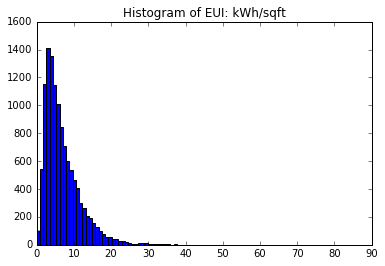

In [323]:
# See the distribution of EUI
plt.hist(rp.EUI,bins = 100)
plt.title("Histogram of EUI: kWh/sqft")
plt.show()

# Linear regression for each variable: EUI vs Each Variable

In [324]:
# This section calculates the R-val when a line is fitted to a plot of EUI vs each variable in data

i = 0
y = eui
r_vals = pd.DataFrame(columns = ["variable", "rval","abs_rval","variable_description"])
for col in rp:
    x = rp[rp.columns[i]]
    if type(x[3]) == str:
        r_vals.loc[len(r_vals)] = [rp.columns[i], None, None, pl['Variable Label'][i]]
    else:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        r_vals.loc[len(r_vals)] = [rp.columns[i], r_value, abs(r_value), pl['Variable Label'][i]]
    i += 1

r_vals.sort_values(by = 'abs_rval', ascending=False).head()

,variable,rval,abs_rval,variable_description
931,EUI,1.000000,1.000000,Energy Use Intensity
842,KWHWTH,0.556486,0.556486,"Electricity usage for water heating, in kilowa..."
848,BTUELWTH,0.556486,0.556486,"Electricity usage for water heating, in thousa..."
846,BTUELSPH,0.512364,0.512364,"Electricity usage for space heating, in thousa..."
840,KWHSPH,0.512364,0.512364,"Electricity usage for space heating, in kilowa..."


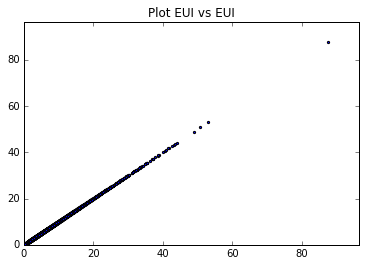

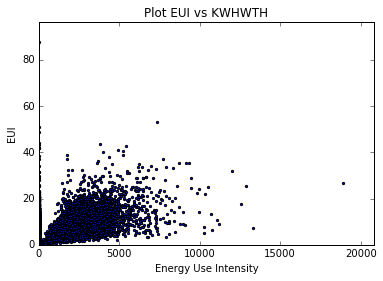

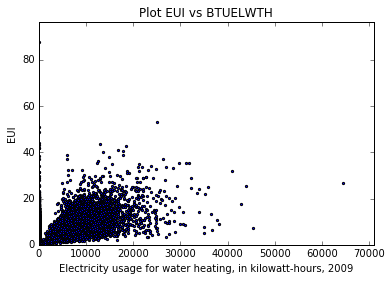

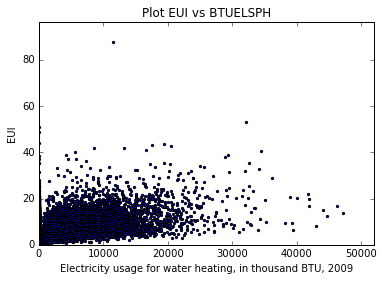

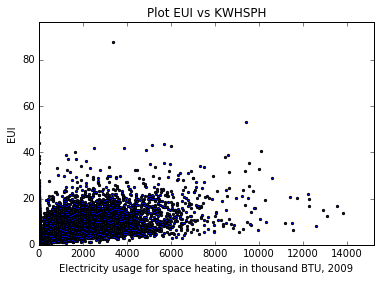

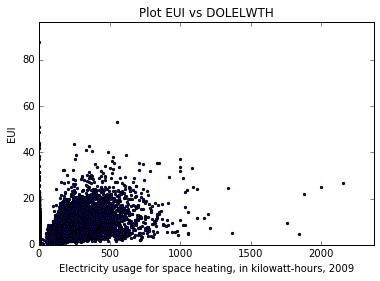

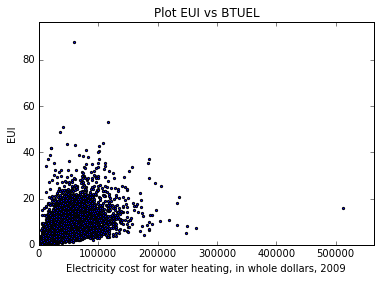

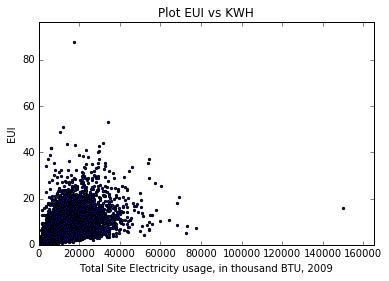

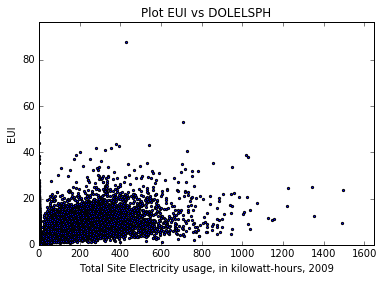

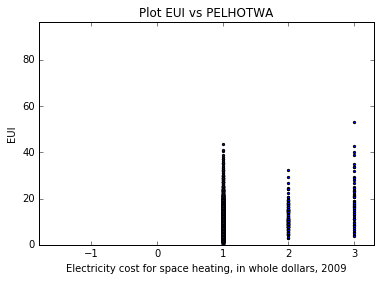

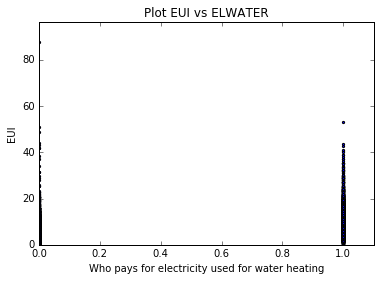

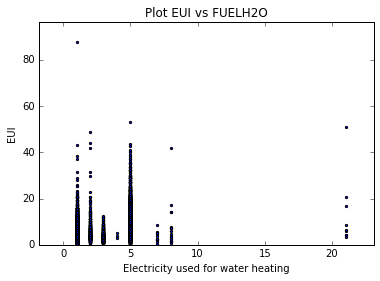

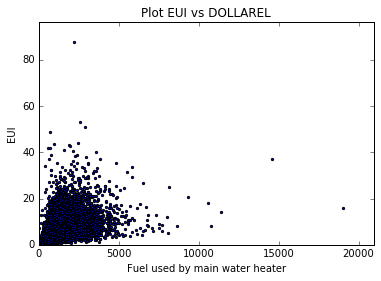

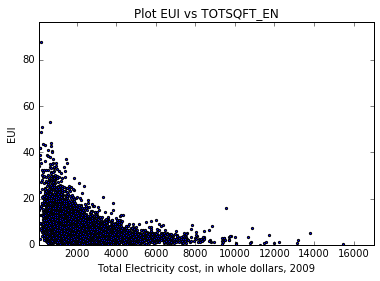

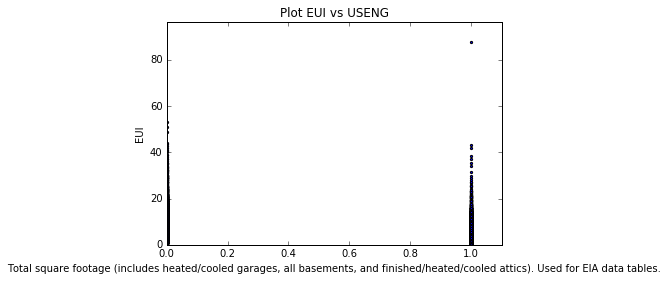

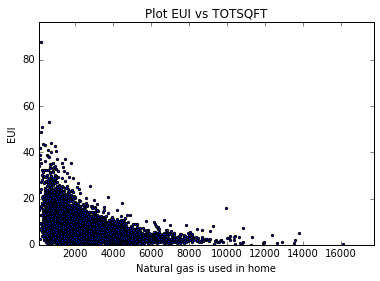

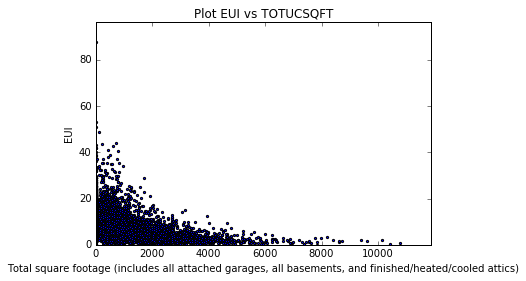

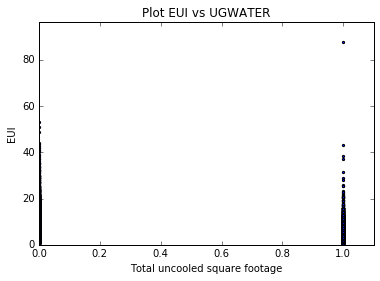

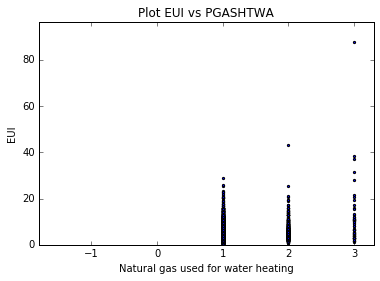

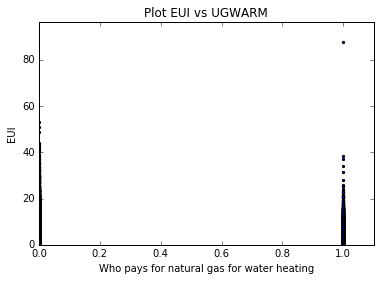

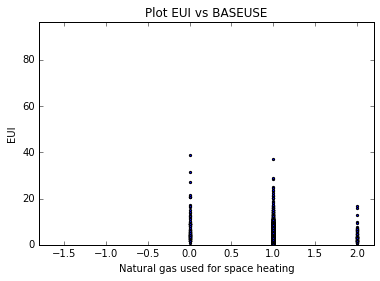

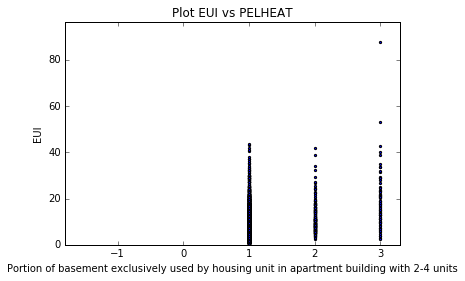

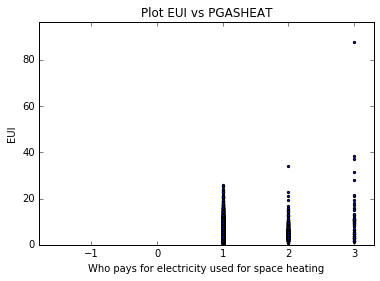

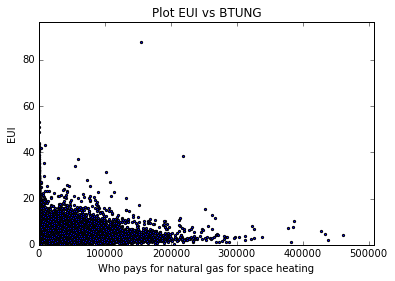

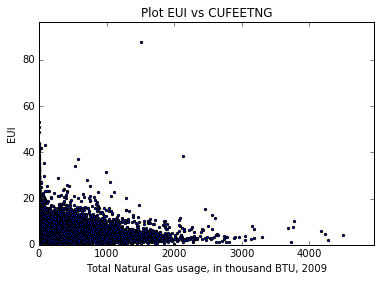

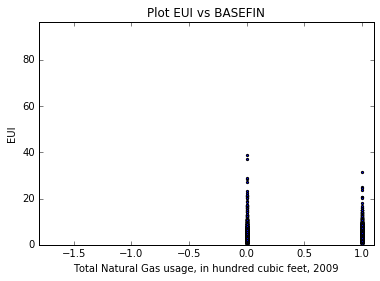

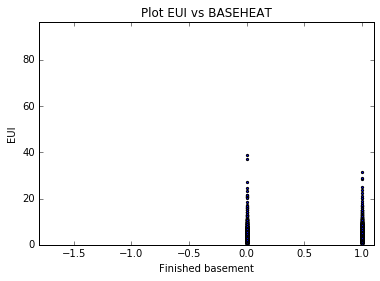

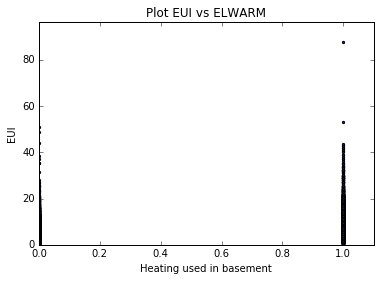

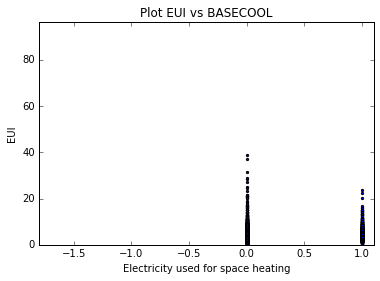

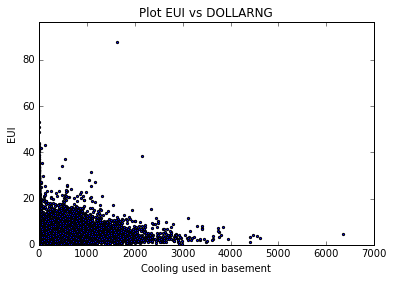

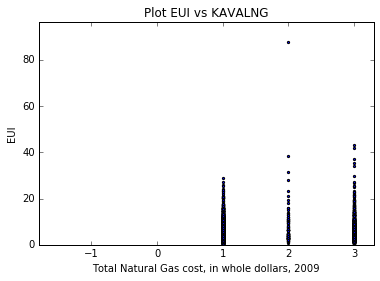

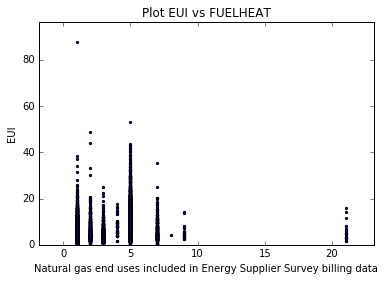

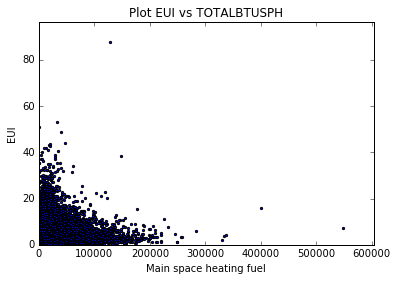

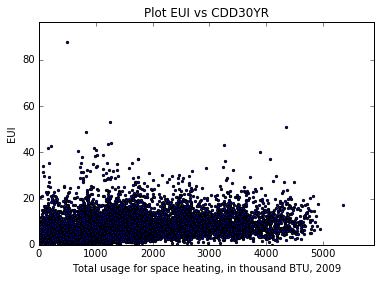

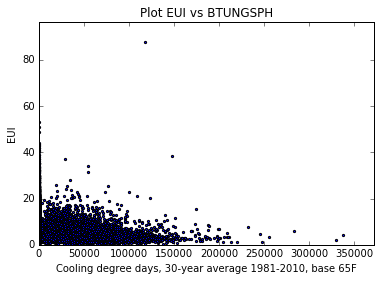

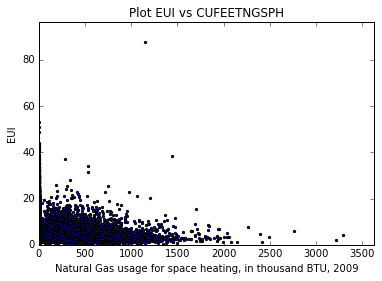

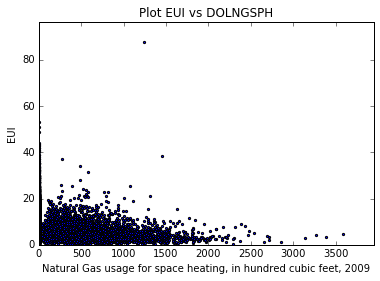

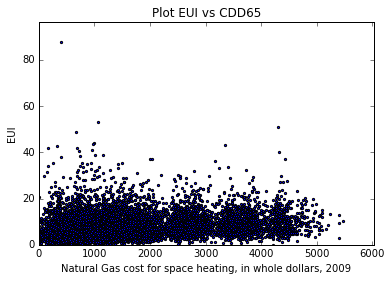

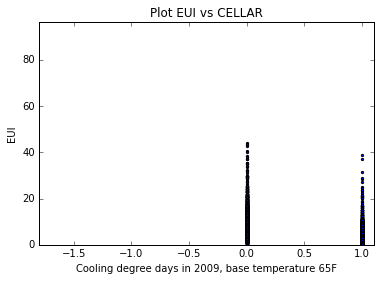

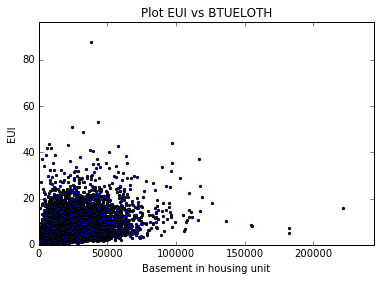

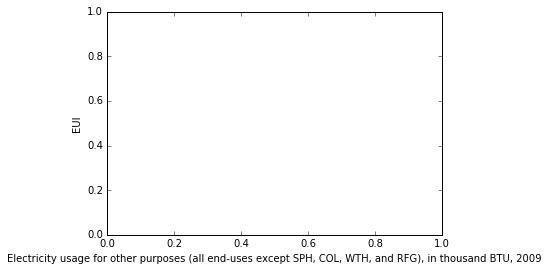

In [325]:
# This section plots the data (EUI vs variable) of the top 40 highest r-values for visual inspection


topr = r_vals.sort_values(by = 'abs_rval', ascending=False) # sort r-values from above with highest at top
topr = topr.iloc[:40]

y = eui # y-axis will be eui in each graph
ymin = min(y)
ymax = max(y) + 0.1*max(y)
i = 0
for var in topr.variable:
    x = rp[var]
    plt.scatter(x,y, marker = ".")
    plt.title("Plot EUI vs " + var)# + ': ' + topr.variable_description.iloc[i])
    plt.xlim([min(x)-0.1*min(x),max(x)+0.1*max(x)])
    plt.ylim([ymin,ymax])
    plt.show()
    plt.ylabel('EUI')
    plt.xlabel(topr.variable_description.iloc[i])
    i += 1

# One Way ANOVA for each variable

In [326]:
# This section performs an ANOVA to determine if a variable affects EUI. This is done for a single variable by 
# comparing two sample distributions of EUI: one in which the variable is less than or equal to the 10th percentile and
# the other in which the variable is greater than or equal to the 90th percentile

i = 0
p_vals = pd.DataFrame(columns = ["variable", "pval", "variable_description","low_sample_count", "high_sample_count",
                                "low_mean", "high_mean"])
for col in rp:
    x = rp[rp.columns[i]]
    if type(x[3]) == str:
        p_vals.loc[len(p_vals)] = [rp.columns[i], None, pl['Variable Label'][i], 0, 0, 0, 0]
        #print("Not Numerical")
    else:
        lower = np.percentile(x,10)
        euilow = rp.EUI[x <= lower]
        # euiL = euilow.mean()
        upper = np.percentile(x,90)
        euihigh = rp.EUI[x >= upper]
        z_stat, p_val = stats.ranksums(euilow, euihigh) 
        p_vals.loc[len(p_vals)] = [rp.columns[i], p_val, pl['Variable Label'][i], euilow.count(), euihigh.count(),
                                  euilow.mean(), euihigh.mean()]
        # euiH = euihigh.mean()
        # print(rp.columns[i] + "--low: " + str(euiL) + " high: " + str(euiH))
        # print(i)
    i += 1

/Users/appledelete/anaconda/envs/Learning/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [327]:
# Examine p-values that meet 95% confidence interval criterion.

ci = p_vals[p_vals.pval <= 0.05]
# confinv = p_vals[p_vals.pval == 0]
ci.sort_values(by = "pval")

# Notes:
# Didn't check to see how normally distributed samples are.
# For those variables with categories, perform n-way anova.

,variable,pval,variable_description,low_sample_count,high_sample_count,low_mean,high_mean
931,EUI,0.000000e+00,Energy Use Intensity,1209.0,1209.0,1.622355,18.105623
46,BASEUSE,0.000000e+00,Portion of basement exclusively used by housin...,8142.0,3829.0,8.162114,4.212152
35,CELLAR,0.000000e+00,Basement in housing unit,2464.0,3941.0,9.034965,4.301398
854,DOLELWTH,0.000000e+00,"Electricity cost for water heating, in whole d...",7271.0,1209.0,5.091133,12.383063
852,DOLELSPH,0.000000e+00,"Electricity cost for space heating, in whole d...",5929.0,1209.0,5.154686,12.122634
848,BTUELWTH,0.000000e+00,"Electricity usage for water heating, in thousa...",7270.0,1209.0,5.090863,13.312309
846,BTUELSPH,0.000000e+00,"Electricity usage for space heating, in thousa...",5929.0,1209.0,5.154686,12.570609
845,BTUEL,0.000000e+00,"Total Site Electricity usage, in thousand BTU,...",1209.0,1209.0,3.133182,12.198291
842,KWHWTH,0.000000e+00,"Electricity usage for water heating, in kilowa...",7270.0,1209.0,5.090863,13.312309
839,KWH,0.000000e+00,"Total Site Electricity usage, in kilowatt-hour...",1209.0,1209.0,3.133182,12.198291


## See recs2009_public_codebook.xlsx file

In [328]:
# Load up codebook
pc = pd.DataFrame.from_csv('cap-data/recs2009_public_codebook_simple.csv', index_col= None, encoding = 'utf-8')

In [329]:
# Separate 
pc['Response Codes']=[x.split('\r') if type(x) == str else x for x in pc['Response Codes']]
pc['Response Labels']=[x.split('\r') if type(x) == str else x for x in pc['Response Labels']]


In [330]:
pc.head(20)
# Next step: expand table (multiple variable names)

,Variable Name,Variable Description,Response Codes,Response Labels,Electricity,Natural Gas,Propane,Fuel Oil,Kerosene
0,DOEID,Unique identifier for each respondent,[00001 - 12083],[Unique identifier for each respondent],NaN,NaN,NaN,NaN,NaN
1,REGIONC,Census Region,"[1, 2, 3, 4]","[Northeast Census Region, Midwest Census Regio...",NaN,NaN,NaN,NaN,NaN
2,DIVISION,Census Division,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[New England Census Division (CT, MA, ME, NH, ...",NaN,NaN,NaN,NaN,NaN
3,REPORTABLE_DOMAIN,Reportable states and groups of states,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[, Connecticut, Maine, New Hampshire, Rhode Is...",NaN,NaN,NaN,NaN,NaN
4,TYPEHUQ,Type of housing unit,"[1, 2, 3, 4, 5]","[Mobile Home, Single-Family Detached, Single-F...",OTH_B,SPH_A,NaN,NaN,NaN
5,NWEIGHT,Final sample weight,NaN,[Final sample weight],NaN,NaN,NaN,NaN,NaN
6,HDD65,"Heating degree days in 2009, base temperature 65F",NaN,"[Heating degree days in 2009, base temperature...","SPH_B, WTH_A",SPH_B,"SPH_B, OTH_B","SPH_B, OTH_B","SPH_B, OTH_B"
7,CDD65,"Cooling degree days in 2009, base temperature 65F",NaN,"[Cooling degree days in 2009, base temperature...",COL_B,NaN,NaN,NaN,NaN
8,HDD30YR,"Heating degree days, 30-year average 1981-2010...",NaN,"[Heating degree days, 30-year average 1981-201...",NaN,NaN,NaN,NaN,NaN
9,CDD30YR,"Cooling degree days, 30-year average 1981-2010...",NaN,"[Cooling degree days, 30-year average 1981-201...",NaN,NaN,NaN,NaN,NaN
